### Author: Sathvik

## Notes
* Model-1 : MultiTaskModel - Non-hierarchical Multitask learning
* Model-2 : ConvModel - Single task (species identification)
* Model-3 : TaxoNet - Hierarchical Multitask learning

* Remarks:
    - Use Kaggle's Python IDE and add the below dataset as an input there. (As the dataset is very large (around 20gb))
    - Link to dataset: https://www.kaggle.com/datasets/vikku7/birdclef-ms/data
    - I have shown all the training and validation accuracies and roc_auc for 1 epoch 

## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import librosa.display as lid
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ExponentialLR
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchaudio
from torchaudio.transforms import Resample
import torchaudio.transforms as T
from torchinfo import summary
from torch.cuda.amp import autocast, GradScaler
from typing import Dict, List, Tuple, Union

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cmap = mpl.colormaps.get_cmap('coolwarm')
device

device(type='cpu')

## Data

In [2]:
base_path = '/kaggle/input/birdclef-ms'
df = pd.read_csv(f'{base_path}/train_metadata_taxonomy.csv')
df.head()

,primary_label,File_path,ORDER1,FAMILY
0,asbfly,asbfly/XC134896.ogg,Passeriformes,Muscicapidae (Old World Flycatchers)
1,asbfly,asbfly/XC164848.ogg,Passeriformes,Muscicapidae (Old World Flycatchers)
2,asbfly,asbfly/XC175797.ogg,Passeriformes,Muscicapidae (Old World Flycatchers)
3,asbfly,asbfly/XC207738.ogg,Passeriformes,Muscicapidae (Old World Flycatchers)
4,asbfly,asbfly/XC209218.ogg,Passeriformes,Muscicapidae (Old World Flycatchers)


## Fixed parameters

In [3]:
class CFG:    
    # Input image size and batch size
    img_size = [224, 224]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # Short-Time Fourier Transform(STFT) parameters
    nfft = 2028       #The number of points in the FFT. A higher nfft value can provide better frequency resolution but will require more computational power and time.
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 1
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('/kaggle/input/birdclef-ms/train_audio/train_audio'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

    df2 = pd.read_csv('/kaggle/input/birdclef-ms/train_metadata.csv')
    species_name = dict(set(zip(df2['primary_label'], df2['scientific_name'])))
    common_name = dict(set(zip(df2['primary_label'], df2['common_name'])))
    
    order_classes = set(df['ORDER1'])
    order_labels = list(range(len(order_classes)))
    label2order = dict(zip(order_labels, order_classes))
    order2label = {v:k for k,v in label2order.items()}

    family_classes = set(df['FAMILY'])
    family_labels = list(range(len(family_classes)))
    label2family = dict(zip(family_labels, family_classes))
    family2label = {v:k for k,v in label2family.items()}

In [4]:
print(CFG.class_names); print(CFG.order_classes); print(CFG.family_classes)

['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2', 'asiope1', 'aspfly1', 'aspswi1', 'barfly1', 'barswa', 'bcnher', 'bkcbul1', 'bkrfla1', 'bkskit1', 'bkwsti', 'bladro1', 'blaeag1', 'blakit1', 'blhori1', 'blnmon1', 'blrwar1', 'bncwoo3', 'brakit1', 'brasta1', 'brcful1', 'brfowl1', 'brnhao1', 'brnshr', 'brodro1', 'brwjac1', 'brwowl1', 'btbeat1', 'bwfshr1', 'categr', 'chbeat1', 'cohcuc1', 'comfla1', 'comgre', 'comior1', 'comkin1', 'commoo3', 'commyn', 'compea', 'comros', 'comsan', 'comtai1', 'copbar1', 'crbsun2', 'cregos1', 'crfbar1', 'crseag1', 'dafbab1', 'darter2', 'eaywag1', 'emedov2', 'eucdov', 'eurbla2', 'eurcoo', 'forwag1', 'gargan', 'gloibi', 'goflea1', 'graher1', 'grbeat1', 'grecou1', 'greegr', 'grefla1', 'grehor1', 'grejun2', 'grenig1', 'grewar3', 'grnsan', 'grnwar1', 'grtdro1', 'gryfra', 'grynig2', 'grywag', 'gybpri1', 'gyhcaf1', 'heswoo1', 'hoopoe', 'houcro1', 'houspa', 'inbrob1', 'indpit1', 'indrob1', 'indrol2', 'indtit1', 'ingori1', 'inpher1', 'insbab1', 'insowl1', 'integr'

In [5]:
taxonomy_dict = {}

# Iterate over the rows of the DataFrame
for _, row in df.iterrows():
    order = row['ORDER1']
    family = row['FAMILY']
    species = row['primary_label']
    
    # Build the nested dictionary structure
    if order not in taxonomy_dict:
        taxonomy_dict[order] = {}
    if family not in taxonomy_dict[order]:
        taxonomy_dict[order][family] = []
    if species not in taxonomy_dict[order][family]:
        taxonomy_dict[order][family].append(species)

# Initialize counters
num_orders = len(taxonomy_dict)
num_families = 0
num_species = 0
MOD_MEDIUM_COUNTS = {}
# Loop through each order, family, and species in the taxonomy
for order, families in taxonomy_dict.items():
    num_families += len(families)
    for family, species in families.items():
        num_species += len(species)
        MOD_MEDIUM_COUNTS[family] = len(species)

# Print the counts
print("Total number of orders:", num_orders)
print("Total number of families:", num_families)
print("Total number of species:", num_species)
# print(MOD_MEDIUM_COUNTS)
n=0
for x,y in MOD_MEDIUM_COUNTS.items():
    n+=y
print(n)
# taxonomy_dict

Total number of orders: 19
Total number of families: 60
Total number of species: 182
182


In [6]:
print(MOD_MEDIUM_COUNTS)

{'Muscicapidae (Old World Flycatchers)': 11, 'Dicruridae (Drongos)': 4, 'Cisticolidae (Cisticolas and Allies)': 5, 'Artamidae (Woodswallows, Bellmagpies, and Allies)': 1, 'Monarchidae (Monarch Flycatchers)': 2, 'Hirundinidae (Swallows)': 2, 'Pycnonotidae (Bulbuls)': 6, 'Oriolidae (Old World Orioles)': 2, 'Acrocephalidae (Reed Warblers and Allies)': 2, 'Sturnidae (Starlings)': 5, 'Leiothrichidae (Laughingthrushes and Allies)': 6, 'Laniidae (Shrikes)': 1, 'Vangidae (Vangas, Helmetshrikes, and Allies)': 2, 'Aegithinidae (Ioras)': 1, 'Fringillidae (Finches, Euphonias, and Allies)': 1, 'Nectariniidae (Sunbirds and Spiderhunters)': 5, 'Timaliidae (Tree-Babblers, Scimitar-Babblers, and Allies)': 2, 'Motacillidae (Wagtails and Pipits)': 5, 'Turdidae (Thrushes and Allies)': 1, 'Chloropseidae (Leafbirds)': 1, 'Phylloscopidae (Leaf Warblers)': 4, 'Stenostiridae (Fairy Flycatchers)': 1, 'Corvidae (Crows, Jays, and Magpies)': 4, 'Passeridae (Old World Sparrows)': 1, 'Pittidae (Pittas)': 1, 'Paridae

In [7]:
df['File_path'] = base_path + '/train_audio/train_audio/' + df.File_path
df['filename'] = df.File_path.map(lambda x: x.split('/')[-1])
df['target'] = df.primary_label.map(CFG.name2label)
df['l_order'] = df.ORDER1.map(CFG.order2label)
df['l_family'] = df.FAMILY.map(CFG.family2label)
df.head()

,primary_label,File_path,ORDER1,FAMILY,filename,target,l_order,l_family
0,asbfly,/kaggle/input/birdclef-ms/train_audio/train_au...,Passeriformes,Muscicapidae (Old World Flycatchers),XC134896.ogg,0,6,18
1,asbfly,/kaggle/input/birdclef-ms/train_audio/train_au...,Passeriformes,Muscicapidae (Old World Flycatchers),XC164848.ogg,0,6,18
2,asbfly,/kaggle/input/birdclef-ms/train_audio/train_au...,Passeriformes,Muscicapidae (Old World Flycatchers),XC175797.ogg,0,6,18
3,asbfly,/kaggle/input/birdclef-ms/train_audio/train_au...,Passeriformes,Muscicapidae (Old World Flycatchers),XC207738.ogg,0,6,18
4,asbfly,/kaggle/input/birdclef-ms/train_audio/train_au...,Passeriformes,Muscicapidae (Old World Flycatchers),XC209218.ogg,0,6,18


In [8]:
# Initialize the StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in sss.split(df, df['target']):
    train_df = df.iloc[train_index]
    valid_df = df.iloc[test_index]

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")
print(train_df.head())
print(train_df.columns)

Num Train: 19567 | Num Valid: 4892
      primary_label                                          File_path  \
17144        litegr  /kaggle/input/birdclef-ms/train_audio/train_au...   
21627        spodov  /kaggle/input/birdclef-ms/train_audio/train_au...   
7725         comsan  /kaggle/input/birdclef-ms/train_audio/train_au...   
8834        eaywag1  /kaggle/input/birdclef-ms/train_audio/train_au...   
11391        greegr  /kaggle/input/birdclef-ms/train_audio/train_au...   

                ORDER1                                   FAMILY      filename  \
17144   Pelecaniformes  Ardeidae (Herons, Egrets, and Bitterns)  XC576994.ogg   
21627    Columbiformes           Columbidae (Pigeons and Doves)  XC463317.ogg   
7725   Charadriiformes     Scolopacidae (Sandpipers and Allies)  XC764652.ogg   
8834     Passeriformes       Motacillidae (Wagtails and Pipits)  XC675728.ogg   
11391   Pelecaniformes  Ardeidae (Herons, Egrets, and Bitterns)  XC678629.ogg   

       target  l_order  l_family 

## Decoders

The following code will decode the raw audio from `.ogg` file and also decode the spectrogram from the `audio` file. Additionally, we will apply Z-Score standardization and Min-Max normalization to ensure consistent inputs to the model.

In [9]:
# Decodes the audio
def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        audio, sr = librosa.load(filepath, sr=CFG.sample_rate)  # Load audio file with fixed sampling rate (CFG.sample_rate)
        if len(audio.shape) > 1:  # stereo -> mono
            audio = librosa.to_mono(audio)
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = len(audio)
        diff_len = abs(target_len - audio_len)
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = np.random.randint(0, diff_len)
            pad2 = diff_len - pad1
            audio = np.pad(audio, (pad1, pad2), mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = np.random.randint(0, diff_len)
            audio = audio[idx:idx + target_len]
        return audio

    def apply_preproc(spec):
        # Standardize
        mean = np.mean(spec)
        std = np.std(spec)
        spec = (spec - mean) / std if std != 0 else spec - mean

        # Normalize using Min-Max
        min_val = np.min(spec)
        max_val = np.max(spec)
        spec = (spec - min_val) / (max_val - min_val) if max_val != min_val else spec - min_val
        return spec

    def get_target(target, len):
        # NumPy-based one-hot encoding.
        # We are using one-hot because using ordinal lables might make model think that the output labels have some kind of inherent order
        target_vector = np.zeros(len)
        target_vector[target] = 1.0
        return target_vector

    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        # Audio to Mel Spectrogram (without decibel conversion to match the first code)
        spec = librosa.feature.melspectrogram(y=audio, sr=CFG.sample_rate, n_fft=CFG.nfft, hop_length=CFG.hop_length, n_mels=CFG.img_size[0])
        # Optionally apply decibel conversion if needed
        spec = librosa.power_to_db(spec, ref=np.max)  # Uncomment if needed
        # Apply normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = np.tile(spec[..., None], [1, 1, 3])
        spec = np.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(path, label, l_order, l_family):
        label = get_target(label,CFG.num_classes)
        l_order = get_target(l_order,len(CFG.order_classes))
        l_family = get_target(l_family, len(CFG.family_classes))
        return decode(path), label, l_order, l_family

    return decode_with_labels if with_labels else decode



## Augmenters
Following code will apply augmentations to audio files. We are using TimeMasking, FreqMasking and TimeStretch

> Note that, these augmentations will be applied to batch of spectrograms rather than single spectrograms.

In [10]:
import torch
import numpy as np
import random
from torchvision import transforms

def build_augmenter():
    augmenters = [
        # Random Cutout for time-masking
        RandomCutout(height_factor=(1.0, 1.0), width_factor=(0.06, 0.12)),
        # Random Cutout for frequency-masking
        RandomCutout(height_factor=(0.06, 0.1), width_factor=(1.0, 1.0)),
    ]

    def augment(img, label, l_order, l_family):
        # Ensure img is a tensor
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).float()
        
        data = {"images": img, "labels": label, "lorder": l_order, "lfamily": l_family}
        
        for augmenter in augmenters:
            if random.random() < 0.35:  # 35% chance to apply each augmenter
                data = augmenter(data)
        
        return data["images"], data["labels"], data["lorder"], data["lfamily"]

    return augment

# Random Cutout Class
class RandomCutout:
    def __init__(self, height_factor=(0.06, 0.1), width_factor=(0.06, 0.1)):
        self.height_factor = height_factor
        self.width_factor = width_factor

    def __call__(self, data):
        img = data["images"]
        height = img.size(1)
        width = img.size(2)
        
        # Calculate cutout size
        h_cutout = int(height * random.uniform(*self.height_factor))
        w_cutout = int(width * random.uniform(*self.width_factor))
        
        # Randomly choose the cutout position
        y = random.randint(0, height - h_cutout)
        x = random.randint(0, width - w_cutout)
        
        # Apply the cutout
        img[:, y:y + h_cutout, x:x + w_cutout] = 0  # Zeroing out the cutout region
        
        return {"images": img, **data}

## Data Pipeline

In [11]:
class CustomDataset(Dataset):
    def __init__(self, paths, labels=None, l_order=None, l_family=None, decode_fn=None, augment_fn=None):
        self.paths = paths
        self.labels = labels
        self.l_order = l_order
        self.l_family = l_family
        self.decode_fn = decode_fn if decode_fn is not None else build_decoder(dim=CFG.audio_len)
        self.augment_fn = augment_fn if augment_fn is not None else build_augmenter()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx] if self.labels is not None else None
        l_order = self.l_order[idx] if self.l_order is not None else None
        l_family = self.l_family[idx] if self.l_family is not None else None

        # Decode the audio
        audio, label, l_order, l_family = self.decode_fn(path, label, l_order, l_family)

        # Augment the audio
        audio, label, l_order, l_family = self.augment_fn(audio, label, l_order, l_family)

        return audio, label, l_order, l_family

def build_dataset(paths, labels=None, l_order=None, l_family=None):
    dataset = CustomDataset(paths, labels, l_order, l_family)
    return dataset

## Build Train and Validation Dataloaders

In [12]:
# Train dataset
train_paths = train_df['File_path'].values
train_targets = train_df['target'].values
train_order_labels = train_df['l_order'].values
train_family_labels = train_df['l_family'].values

# Create training dataset with augmentation
train_ds = build_dataset(
    paths=train_paths,
    labels=train_targets,
    l_order=train_order_labels,
    l_family=train_family_labels
)

# Validation dataset
valid_paths = valid_df['File_path'].values
valid_targets = valid_df['target'].values
valid_order_labels = valid_df['l_order'].values
valid_family_labels = valid_df['l_family'].values

# Create validation dataset without augmentation
valid_ds = build_dataset(
    paths=valid_paths,
    labels=valid_targets,
    l_order=valid_order_labels,
    l_family=valid_family_labels
)

In [13]:
# To check the shape and type of the elements in the train_ds
for images, labels, l_order, l_family in train_ds:
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print(labels)
    print("l_order shape:", l_order.shape)
    print(l_order)
    print("l_family shape:", l_family.shape)
    print(l_family)
    break  # Just to check the first batch, remove if you want to iterate through all


Images shape: torch.Size([224, 224, 3])
Labels shape: (182,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
l_order shape: (19,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
l_family shape: (60,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Visualization 🔭
To ensure our pipeline is generating **spectrogram** and its associate **label** correctly, we'll check some samples from a batch.

Specs shape: (9, 224, 224, 3)
Specs shape after squeezing: (9, 224, 224)


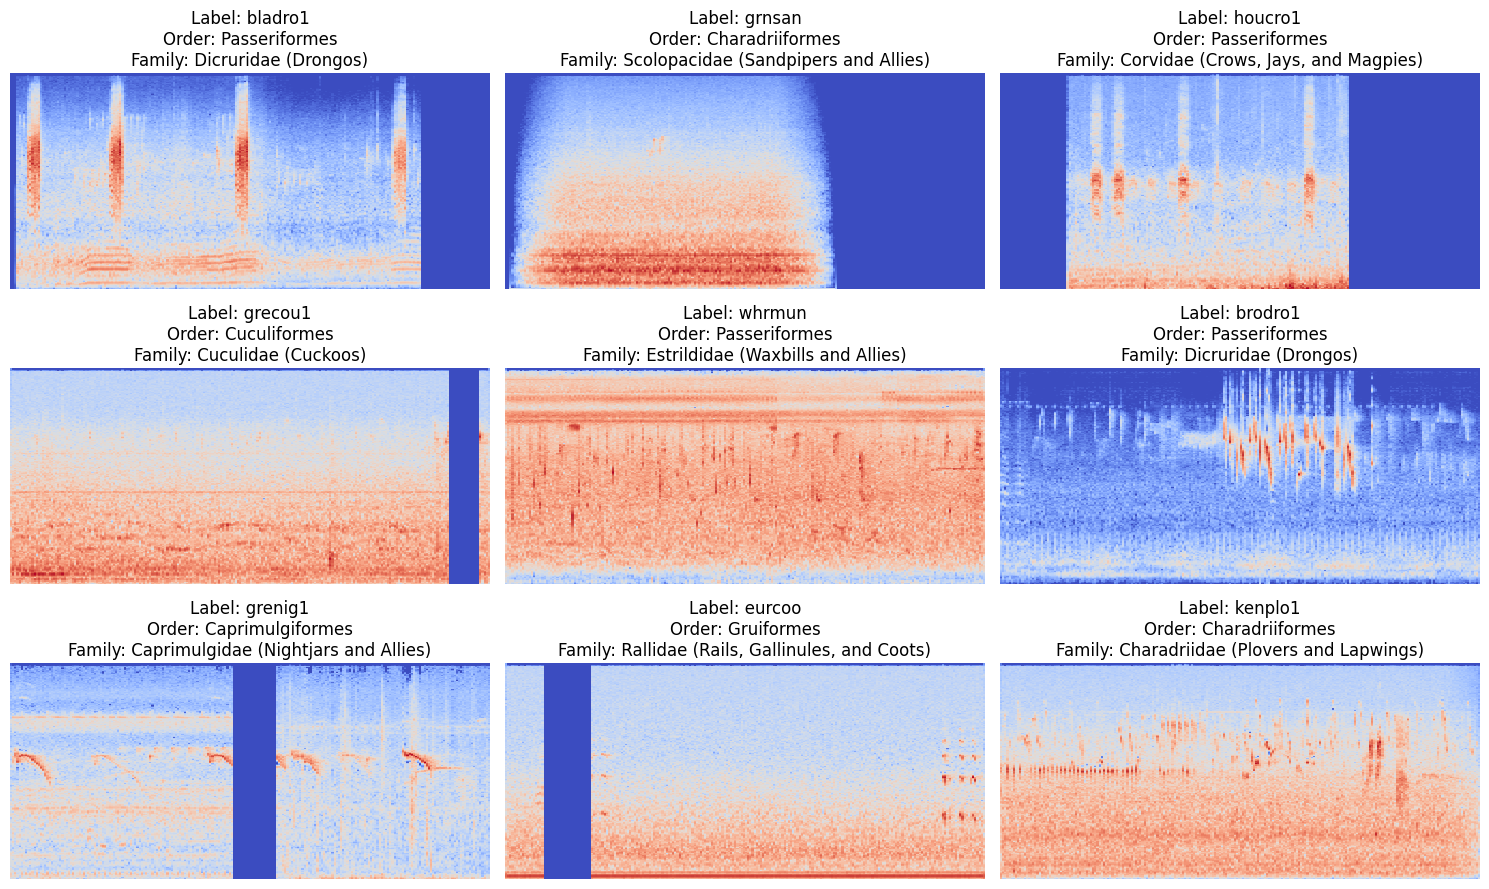

In [14]:
def plot_batch(batch, row=3, col=3, label2name=None, order2name=None, family2name=None):
    """Plot one batch of data"""
    specs, tars, l_order, l_family = batch

    plt.figure(figsize=(col * 5, row * 3))
    for idx in range(min(row * col, len(specs))):  # Ensure we don't exceed available specs
        ax = plt.subplot(row, col, idx + 1)
        
        # Assuming specs is a 3D array (batch_size, height, width)
        lid.specshow(np.array(specs[idx]), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')

        title = ""
        
        if tars is not None:
            label = tars[idx].argmax()  # Directly use argmax on the NumPy array
            name = label2name[label]
            title += f"Label: {name}\n"
        
        if l_order is not None:
            order = l_order[idx].argmax()  # Use argmax to get the index of the highest value
            order_name = order2name[order]
            title += f"Order: {order_name}\n"
        
        if l_family is not None:
            family = l_family[idx].argmax()  # Use argmax to get the index of the highest value
            family_name = family2name[family]
            title += f"Family: {family_name}"

        plt.title(title.strip())  # Remove any trailing newline
        plt.axis('off')  # Optionally turn off axis for better visualization

    plt.tight_layout()
    plt.show()

# Get a single batch from the CustomDataset
batch_size = 9  # Define your desired batch size
batch_indices = np.random.choice(len(train_ds), batch_size, replace=False)  # Randomly select indices
batch = [train_ds[idx] for idx in batch_indices]  # Retrieve the batch

# Unpack the batch
specs, tars, l_order, l_family = zip(*batch)  # Unzip the batch into separate variables

# Convert to appropriate formats
specs = np.array(specs)
tars = np.array(tars)
l_order = np.array(l_order)
l_family = np.array(l_family)
print("Specs shape:", specs.shape) # 3(rgb) is for the sake of format of input for efficientnet
specs = np.mean(specs, axis=-1) # removing the 3(rgb) to make the plots use coolwarm as it expects 2D
print("Specs shape after squeezing:", specs.shape)
# Now call the plot function
plot_batch((specs, tars, l_order, l_family), label2name=CFG.label2name, order2name=CFG.label2order, family2name=CFG.label2family)

## MTL model

In [15]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_species_classes, num_order_classes, num_family_classes):
        super(MultiTaskModel, self).__init__()
        
        # Pretrained EfficientNet backbone
        self.backbone = models.efficientnet_v2_s(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Remove the final classification layer
        
        # Species task layers
        self.species_fc = nn.Linear(1280, 512)  # Task-specific FC layer for species
        self.species_class = nn.Linear(512, num_species_classes)  # Classification layer for species

        # Order task layers
        self.order_fc = nn.Linear(1280, 512)  # Task-specific FC layer for order
        self.order_class = nn.Linear(512, num_order_classes)  # Classification layer for order

        # Family task layers
        self.family_fc = nn.Linear(1280, 512)  # Task-specific FC layer for family
        self.family_class = nn.Linear(512, num_family_classes)  # Classification layer for family

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        features = self.backbone(x)  # Output shape: (batch_size, 1280)
        pooled_features = features.view(features.size(0), -1)  # Flatten: (batch_size, 1280)

        # Species branch
        species_output = self.relu(self.species_fc(pooled_features))
        species_output = self.dropout(species_output)
        species_output = self.species_class(species_output)

        # Order branch
        order_output = self.relu(self.order_fc(pooled_features))
        order_output = self.dropout(order_output)
        order_output = self.order_class(order_output)

        # Family branch
        family_output = self.relu(self.family_fc(pooled_features))
        family_output = self.dropout(family_output)
        family_output = self.family_class(family_output)

        return species_output, order_output, family_output

# Define the model
num_species_classes = CFG.num_classes  # Number of species classes
num_order_classes = len(CFG.order_classes)  # Number of order classes
num_family_classes = len(CFG.family_classes)  # Number of family classes

model = MultiTaskModel(num_species_classes, num_order_classes, num_family_classes).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3)  # Adjust the learning rate as needed
# Define loss functions
criterion = {
    'species': nn.CrossEntropyLoss(),  # For species classification
    'order': nn.CrossEntropyLoss(),    # For order classification
    'family': nn.CrossEntropyLoss()    # For family classification
}

print(summary(model, input_size=(64, 3, 224, 224), device=device))  # Batch size, channels, height, width



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 125MB/s]


Layer (type:depth-idx)                                       Output Shape              Param #
MultiTaskModel                                               [64, 182]                 --
├─EfficientNet: 1-1                                          [64, 1280]                --
│    └─Sequential: 2-1                                       [64, 1280, 7, 7]          --
│    │    └─Conv2dNormActivation: 3-1                        [64, 24, 112, 112]        696
│    │    └─Sequential: 3-2                                  [64, 24, 112, 112]        10,464
│    │    └─Sequential: 3-3                                  [64, 48, 56, 56]          303,552
│    │    └─Sequential: 3-4                                  [64, 64, 28, 28]          589,184
│    │    └─Sequential: 3-5                                  [64, 128, 14, 14]         917,680
│    │    └─Sequential: 3-6                                  [64, 160, 14, 14]         3,463,840
│    │    └─Sequential: 3-7                                  [64, 25

## ConvModel

In [16]:
class ConvModel(nn.Module):
    def __init__(self, num_species_classes):
        super(ConvModel, self).__init__()
        
        # Pretrained EfficientNet backbone
        self.backbone = models.efficientnet_v2_s(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Remove the final classification layer
        
        # Species task layers
        self.species_fc = nn.Linear(1280, 512)  # Task-specific FC layer for species
        self.species_class = nn.Linear(512, num_species_classes)  # Classification layer for species

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        features = self.backbone(x)  # Output shape: (batch_size, 1280)
        pooled_features = features.view(features.size(0), -1)  # Flatten: (batch_size, 1280)
        
        # Species branch
        species_output = self.relu(self.species_fc(pooled_features))
        species_output = self.dropout(species_output)
        species_output = self.species_class(species_output)

        return species_output

# Define the model
num_species_classes = CFG.num_classes  # Number of species classes

model2 = ConvModel(num_species_classes).to(device)

optimizer2 = optim.AdamW(model2.parameters(), lr=1e-3)  # Adjust the learning rate as needed
# Define loss functions
criterion2 = {
    'species': nn.CrossEntropyLoss()  # For species classification
}

print(summary(model2, input_size=(64, 3, 224, 224), device=device))  # Batch size, channels, height, width


Layer (type:depth-idx)                                       Output Shape              Param #
ConvModel                                                    [64, 182]                 --
├─EfficientNet: 1-1                                          [64, 1280]                --
│    └─Sequential: 2-1                                       [64, 1280, 7, 7]          --
│    │    └─Conv2dNormActivation: 3-1                        [64, 24, 112, 112]        696
│    │    └─Sequential: 3-2                                  [64, 24, 112, 112]        10,464
│    │    └─Sequential: 3-3                                  [64, 48, 56, 56]          303,552
│    │    └─Sequential: 3-4                                  [64, 64, 28, 28]          589,184
│    │    └─Sequential: 3-5                                  [64, 128, 14, 14]         917,680
│    │    └─Sequential: 3-6                                  [64, 160, 14, 14]         3,463,840
│    │    └─Sequential: 3-7                                  [64, 25

In [17]:
# Function to save the best model
def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

# Function to load the best model
def load_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename))
    model.eval()  # Set the model to evaluation mode

In [18]:
train_loader = DataLoader(train_ds,batch_size=CFG.batch_size,shuffle=True)
valid_loader = DataLoader(valid_ds,batch_size=CFG.batch_size,shuffle=False)

## MTL Training

In [19]:
class FAMO:
    """
    Fast Adaptive Multitask Optimization.
    """
    def __init__(
        self,
        n_tasks: int,
        device: torch.device,
        gamma: float = 0.01,   # the regularization coefficient
        w_lr: float = 0.025,   # the learning rate of the task logits
        max_norm: float = 1.0, # the maximum gradient norm
    ):
        self.min_losses = torch.zeros(n_tasks).to(device)
        self.w = torch.tensor([0.0] * n_tasks, device=device, requires_grad=True)
        self.w_opt = torch.optim.Adam([self.w], lr=w_lr, weight_decay=gamma)
        self.max_norm = max_norm
        self.n_tasks = n_tasks
        self.device = device
    
    def set_min_losses(self, losses):
        self.min_losses = losses

    def get_weighted_loss(self, losses):
        self.prev_loss = losses
        z = F.softmax(self.w, -1)
        D = losses - self.min_losses + 1e-8
        c = (z / D).sum().detach()
        loss = (D.log() * z / c).sum()
        return loss

    def update(self, curr_loss):
        delta = (self.prev_loss - self.min_losses + 1e-8).log() - \
                (curr_loss      - self.min_losses + 1e-8).log()
        with torch.enable_grad():
            d = torch.autograd.grad(F.softmax(self.w, -1),
                                    self.w,
                                    grad_outputs=delta.detach())[0]
        self.w_opt.zero_grad()
        self.w.grad = d
        self.w_opt.step()

    def backward(
        self,
        losses: torch.Tensor,
        shared_parameters: Union[
            List[torch.nn.parameter.Parameter], torch.Tensor
        ] = None,
    ) -> Union[torch.Tensor, None]:
        """

        Parameters
        ----------
        losses :
        shared_parameters :
        task_specific_parameters :
        last_shared_parameters : parameters of last shared layer/block
        Returns
        -------
        Loss, extra outputs
        """
        loss = self.get_weighted_loss(losses=losses)
        loss.backward()
        if self.max_norm > 0 and shared_parameters is not None:
            torch.nn.utils.clip_grad_norm_(shared_parameters, self.max_norm)
        return loss

In [20]:
# # Load the state dictionary from the file
# state_dict = torch.load("/kaggle/input/best-species-model-weights-pth/best_species_model.weights.pth")
# model.load_state_dict(state_dict)

In [21]:
# Initialize FAMO optimizer with your model and objectives
famo_optimizer = FAMO(n_tasks=3, device=device)  # Adjust the number of tasks accordingly
model.to(device)

scaler = GradScaler()  # For mixed precision

best_species_auc = 0.0
best_family_auc = 0.0
best_order_auc = 0.0

# Freeze EfficientNet backbone for the first few epochs
for param in model.backbone.parameters():
    param.requires_grad = False

# Define gradual unfreezing parameters
num_epochs_before_unfreeze = 2
total_epochs = CFG.epochs
unfreeze_frequency = 2

# Get the total number of parameters in the model's backbone
backbone_parameters = list(model.backbone.parameters())
num_parameters = len(backbone_parameters)

# Calculate how many parameters to unfreeze per step, ensuring at least 1
unfreeze_steps = (total_epochs - num_epochs_before_unfreeze) // unfreeze_frequency
unfreeze_params_per_step = max(1, num_parameters // unfreeze_steps)  # At least 1 parameter per step

unfrozen_params_count = 0

for epoch in range(total_epochs):
    model.train()

    # Gradually unfreeze parameters after the initial freeze period
    if epoch >= num_epochs_before_unfreeze and unfrozen_params_count < num_parameters:
        if (epoch - num_epochs_before_unfreeze) % unfreeze_frequency == 0:
            # Determine how many parameters to unfreeze at this step
            params_to_unfreeze = min(unfrozen_params_count + unfreeze_params_per_step, num_parameters)
            
            # Unfreeze the specified parameters
            for idx in range(unfrozen_params_count, params_to_unfreeze):
                backbone_parameters[idx].requires_grad = True

            # Update count of unfrozen parameters
            unfrozen_params_count = params_to_unfreeze
            print(f"Unfroze {unfrozen_params_count} parameters at epoch {epoch + 1}")

    # Optional: Log number of trainable parameters at each epoch
    print(f"Epoch {epoch + 1}: {sum(p.requires_grad for p in model.parameters())} parameters require gradients.")

    # Training loop
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{total_epochs} [Training]")

    for images, species_labels, order_labels, family_labels in train_progress_bar:
        optimizer.zero_grad()

        # Move data to device
        images = images.permute(0, 3, 1, 2).to(device)
        species_labels = species_labels.to(device)
        order_labels = order_labels.to(device)
        family_labels = family_labels.to(device)

        species_labels = torch.argmax(species_labels, dim=1)  # Converts shape from (64, 182) to (64,)
        order_labels = torch.argmax(order_labels, dim=1)  # Converts shape from (64, 182) to (64,)
        family_labels = torch.argmax(family_labels, dim=1)  # Converts shape from (64, 182) to (64,)
        

        # Mixed precision forward pass
        with autocast():
            # Forward pass
            species_output, order_output, family_output = model(images)
            
            # Calculate losses
            loss_species = criterion['species'](species_output, species_labels)
            loss_order = criterion['order'](order_output, order_labels)
            loss_family = criterion['family'](family_output, family_labels)
            
            losses = torch.stack([loss_species, loss_order, loss_family])

            # Use FAMO to calculate the weighted loss
            total_loss = famo_optimizer.get_weighted_loss(losses)

        # Scales the loss, and calls backward()
        scaler.scale(total_loss).backward()
        
        # Update FAMO's task weights
        famo_optimizer.update(losses)

        # Update weights
        scaler.step(optimizer)
        scaler.update()

        # Optionally, update tqdm with the running loss for the current batch
        train_progress_bar.set_postfix({"Loss": total_loss.item()})

    # Validation phase
    model.eval()
    species_correct, order_correct, family_correct = 0, 0, 0  # For accuracy
    total_samples = 0  # For accuracy
    
    with torch.no_grad():
        val_species_outputs, val_order_outputs, val_family_outputs = [], [], []
        val_species_labels, val_order_labels, val_family_labels = [], [], []
    
        val_progress_bar = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{total_epochs} [Validation]")
        
        for val_images, val_species_labels_batch, val_order_labels_batch, val_family_labels_batch in val_progress_bar:
            # Move data to device
            val_images = val_images.permute(0, 3, 1, 2).to(device)
            val_species_labels_batch = val_species_labels_batch.to(device)
            val_order_labels_batch = val_order_labels_batch.to(device)
            val_family_labels_batch = val_family_labels_batch.to(device)
            
            # Mixed precision inference
            with autocast():
                species_output, order_output, family_output = model(val_images)
            
            # Apply softmax to get probabilities
            species_probs = torch.softmax(species_output, dim=1)
            order_probs = torch.softmax(order_output, dim=1)
            family_probs = torch.softmax(family_output, dim=1)

            # Append outputs and labels for later use
            val_species_outputs.append(species_probs)
            val_order_outputs.append(order_probs)
            val_family_outputs.append(family_probs)
            
            val_species_labels.append(val_species_labels_batch)
            val_order_labels.append(val_order_labels_batch)
            val_family_labels.append(val_family_labels_batch)
    
            # Calculate accuracy using torch.argmax
            species_pred = torch.argmax(species_probs, dim=1)
            order_pred = torch.argmax(order_probs, dim=1)
            family_pred = torch.argmax(family_probs, dim=1)

            # Compare predicted indices with true class indices (one-hot encoded)
            species_correct += (species_pred == torch.argmax(val_species_labels_batch, dim=1)).sum().item()
            order_correct += (order_pred == torch.argmax(val_order_labels_batch, dim=1)).sum().item()
            family_correct += (family_pred == torch.argmax(val_family_labels_batch, dim=1)).sum().item()
    
            total_samples += val_images.size(0)
    
        # Concatenate tensors on device
        val_species_outputs = torch.cat(val_species_outputs)
        val_order_outputs = torch.cat(val_order_outputs)
        val_family_outputs = torch.cat(val_family_outputs)
        
        val_species_labels = torch.cat(val_species_labels)
        val_order_labels = torch.cat(val_order_labels)
        val_family_labels = torch.cat(val_family_labels)
    
        # Move to CPU for AUC calculation
        val_species_outputs = val_species_outputs.cpu().numpy()
        val_order_outputs = val_order_outputs.cpu().numpy()
        val_family_outputs = val_family_outputs.cpu().numpy()
        
        val_species_labels = val_species_labels.cpu().numpy()  
        val_order_labels = val_order_labels.cpu().numpy()      
        val_family_labels = val_family_labels.cpu().numpy()    
    
        # Calculate AUCs
        val_species_auc = roc_auc_score(val_species_labels, val_species_outputs, multi_class='ovr')
        val_order_auc = roc_auc_score(val_order_labels, val_order_outputs, multi_class='ovr')
        val_family_auc = roc_auc_score(val_family_labels, val_family_outputs, multi_class='ovr')
    
        # Calculate accuracies
        species_accuracy = species_correct / total_samples
        order_accuracy = order_correct / total_samples
        family_accuracy = family_correct / total_samples
    
        # Save the best models
        if val_species_auc > best_species_auc:
            best_species_auc = val_species_auc
            save_checkpoint(model, "best_species_model.weights.pth")
    
        if val_family_auc > best_family_auc:
            best_family_auc = val_family_auc
            save_checkpoint(model, "best_family_model.weights.pth")
    
        if val_order_auc > best_order_auc:
            best_order_auc = val_order_auc
            save_checkpoint(model, "best_order_model.weights.pth")
    
    print(f"Epoch {epoch + 1}/{total_epochs}, Species AUC: {float(val_species_auc):.4f}, Family AUC: {float(val_family_auc):.4f}, Order AUC: {float(val_order_auc):.4f}")
    print(f"Species Accuracy: {species_accuracy:.4f}, Family Accuracy: {family_accuracy:.4f}, Order Accuracy: {order_accuracy:.4f}")


/tmp/ipykernel_17/932739040.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision
/opt/conda/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1: 12 parameters require gradients.


Epoch 1/1 [Training]:   0%|          | 0/306 [00:00<?, ?it/s]/tmp/ipykernel_17/932739040.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/1 [Validation]:   0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_17/932739040.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/1 [Validation]: 100%|██████████| 77/77 [16:25<00:00, 12.80s/it]


Epoch 1/1, Species AUC: 0.7707, Family AUC: 0.7740, Order AUC: 0.7597
Species Accuracy: 0.1231, Family Accuracy: 0.2120, Order Accuracy: 0.4655


## ConvModel Training

In [22]:
scaler = GradScaler()  # For mixed precision

best_species_auc2 = 0.0  # Initialize best AUC

# Freeze backbone parameters initially
for param in model2.backbone.parameters():
    param.requires_grad = False

# Gradual unfreezing parameters
num_epochs_before_unfreeze2 = 2
total_epochs2 = CFG.epochs
unfreeze_frequency2 = 2

# Get the total number of parameters in the backbone
backbone_parameters2 = list(model2.backbone.parameters())
num_parameters2 = len(backbone_parameters2)
unfreeze_steps2 = (total_epochs2 - num_epochs_before_unfreeze2) // unfreeze_frequency2
unfreeze_params_per_step2 = max(1, num_parameters2 // unfreeze_steps2)
unfrozen_params_count2 = 0

for epoch2 in range(total_epochs2):
    model2.train()

    # Gradually unfreeze parameters after the initial freeze period
    if epoch2 >= num_epochs_before_unfreeze2 and unfrozen_params_count2 < num_parameters2:
        if (epoch2 - num_epochs_before_unfreeze2) % unfreeze_frequency2 == 0:
            params_to_unfreeze2 = min(unfrozen_params_count2 + unfreeze_params_per_step2, num_parameters2)
            for idx in range(unfrozen_params_count2, params_to_unfreeze2):
                backbone_parameters2[idx].requires_grad = True
            unfrozen_params_count2 = params_to_unfreeze2
            print(f"Unfroze {unfrozen_params_count2} parameters at epoch {epoch2 + 1}")

    # Training loop
    train_progress_bar2 = tqdm(train_loader, desc=f"Epoch {epoch2 + 1}/{total_epochs2} [Training]")

    for images, species_labels, order_labels, family_labels in train_progress_bar2:
        optimizer2.zero_grad()

        # Move data to device
        images = images.permute(0, 3, 1, 2).to(device)
        species_labels = torch.argmax(species_labels, dim=1).to(device)

        # Mixed precision forward pass
        with autocast():
            species_output = model2(images)
            loss_species = criterion2['species'](species_output, species_labels)

        scaler.scale(loss_species).backward()
        scaler.step(optimizer2)
        scaler.update()

        # Update tqdm
        train_progress_bar2.set_postfix({"Loss": loss_species.item()})

    # Validation phase
    model2.eval()
    species_correct, total_samples = 0, 0
    
    with torch.no_grad():
        val_species_outputs, val_species_labels = [], []

        val_progress_bar = tqdm(valid_loader, desc=f"Epoch {epoch2 + 1}/{total_epochs2} [Validation]")

        for val_images, val_species_labels_batch, *_ in val_progress_bar:
            val_images = val_images.permute(0, 3, 1, 2).to(device)
            val_species_labels_batch = torch.argmax(val_species_labels_batch, dim=1).to(device)

            try:
                # Apply numerically stable softmax
                species_output = model2(val_images)
                stable_logits = species_output - species_output.max(dim=1, keepdim=True)[0]
                species_probs = torch.softmax(stable_logits, dim=1)

                # Check for NaN/Inf values in probabilities
                if torch.any(torch.isnan(species_probs)) or torch.any(torch.isinf(species_probs)):
                    print(f"NaN/Inf detected in softmax probabilities at epoch {epoch2 + 1}")
                    continue  # Skip this batch and proceed to the next one

                val_species_outputs.append(species_probs.cpu())
                val_species_labels.append(val_species_labels_batch.cpu())

                species_pred = torch.argmax(species_probs, dim=1)
                species_correct += (species_pred == val_species_labels_batch).sum().item()
                total_samples += val_images.size(0)

            except Exception as e:
                print(f"Error during softmax operation in epoch {epoch2 + 1}: {e}")
                continue  # Skip this batch and proceed to the next one

        try:
            # Concatenate tensors for AUC
            val_species_outputs = torch.cat(val_species_outputs).numpy()
            val_species_labels = torch.cat(val_species_labels).numpy()

            # Calculate ROC AUC
            val_species_auc = roc_auc_score(val_species_labels, val_species_outputs, multi_class='ovr')
            species_accuracy = species_correct / total_samples

            if val_species_auc > best_species_auc2:
                best_species_auc2 = val_species_auc
                save_checkpoint(model2, "best_species_model.weights2.pth")

            print(f"Epoch {epoch2 + 1}/{total_epochs2}, Species AUC: {float(val_species_auc):.4f}")
            print(f"Species Accuracy: {species_accuracy:.4f}")
        
        except Exception as e:
            print(f"Error during AUC computation in epoch {epoch2 + 1}: {e}")
            continue  # Skip this validation step if AUC computation fails

/tmp/ipykernel_17/2496609356.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision
/opt/conda/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/1 [Training]:   0%|          | 0/306 [00:00<?, ?it/s]/tmp/ipykernel_17/2496609356.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/1 [Validation]: 100%|██████████| 77/77 [17:14<00:00, 13.44s/it]


Epoch 1/1, Species AUC: 0.7690
Species Accuracy: 0.1286


# TaxoNet

In [23]:
def hierarchical_containment_layer_sum_activation(x):
    return torch.tanh(torch.sum(x, dim=-1, keepdim=True))

# def other_activation(x):
#     return 1.0 - torch.max(x, dim=-1, keepdim=True)[0]

def partition(n, prop_list):
    prop_list = np.array(prop_list, dtype='float32')
    ideal_part = n * prop_list
    round_part = ideal_part.astype(int)
    missing = n - round_part.sum()
    for _ in range(missing):
        idx = (ideal_part - round_part).argmax()
        round_part[idx] += 1
    return list(round_part)

class L2RegularizedLinear(nn.Linear):
    def __init__(self, in_features, out_features, wd, bias=True):
        super().__init__(in_features, out_features, bias)
        self.wd = wd
        
    def forward(self, x):
        # Add L2 regularization during forward pass
        if self.training:
            self.l2_reg = self.wd * torch.sum(torch.pow(self.weight, 2))
        return super().forward(x)

class TaxoNet(nn.Module):
    def __init__(self, n_orders=19, n_families=60, n_species=182, base_wd=0.001):
        super().__init__()
        
        # EfficientNet Backbone
        self.backbone = models.efficientnet_v2_s(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Remove the final classification layer
        
        # Calculate flattened size based on EfficientNet output
        self.flat_size = 1280  # EfficientNet output features
        
        # Coarse level with L2 regularization - Changed to n_orders outputs
        self.coarse_layer = L2RegularizedLinear(
            self.flat_size, n_orders, wd=base_wd/43.0, bias=False
        )
        nn.init.normal_(self.coarse_layer.weight)
        
        # Rest of the initialization remains same...
        medium_children_counts = [MOD_MEDIUM_COUNTS[k] for k in sorted(MOD_MEDIUM_COUNTS.keys())]
        med_props = np.array(medium_children_counts) / float(sum(medium_children_counts))
        self.n_hidden_units = 512
        self.class_sublayer_sizes = partition(self.n_hidden_units, med_props)
        self.n_hidden_units = sum(self.class_sublayer_sizes)
        
        self.medium_layer = L2RegularizedLinear(
            self.flat_size, self.n_hidden_units, wd=base_wd, bias=False
        )
        nn.init.kaiming_normal_(self.medium_layer.weight)
        
        self.medium_nodes = nn.ModuleList()
        self.fine_sublayers = nn.ModuleList()
        
        for sublayer_size, fine_count in zip(self.class_sublayer_sizes, medium_children_counts):
            medium_node = L2RegularizedLinear(
                sublayer_size, 1, wd=base_wd/43.0, bias=False
            )
            nn.init.normal_(medium_node.weight)
            self.medium_nodes.append(medium_node)
            
            fine_node = L2RegularizedLinear(
                sublayer_size, fine_count, 
                wd=base_wd/(43.0/max(1, fine_count)), bias=False
            )
            nn.init.kaiming_normal_(fine_node.weight)
            self.fine_sublayers.append(fine_node)
    
    def forward(self, x):
        # Feature extraction using EfficientNet
        x = self.backbone(x)
        
        # Coarse prediction (raw logits)
        y_coarse = self.coarse_layer(x)
        
        # Medium features
        medium_features = F.relu(self.medium_layer(x))
        
        medium_outputs = []
        fine_outputs = []
        start = 0
        
        for idx, (medium_node, fine_node, size) in enumerate(zip(
            self.medium_nodes, self.fine_sublayers, self.class_sublayer_sizes)):
            
            medium_slice = medium_features[:, start:start+size]
            medium_out = medium_node(medium_slice)
            medium_outputs.append(medium_out)
            
            fine_out = fine_node(medium_slice)
            fine_outputs.append(fine_out)
            
            start += size
        
        y_medium = torch.cat(medium_outputs, dim=1)
        y_fine = torch.cat(fine_outputs, dim=1)
        
        return y_coarse, y_medium, y_fine


model3 = TaxoNet().to(device)
print(model3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TaxoNet(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24,

In [24]:
class HierarchicalLoss(nn.Module):
    def __init__(self, coarse_weight=1.0, medium_weight=1.0, fine_weight=1.0):
        super().__init__()
        self.coarse_weight = coarse_weight
        self.medium_weight = medium_weight
        self.fine_weight = fine_weight
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, outputs, targets):
        coarse_out, medium_out, fine_out = outputs
        coarse_target, medium_target, fine_target = targets
        
        coarse_loss = self.criterion(coarse_out, coarse_target)
        medium_loss = self.criterion(medium_out, medium_target)
        fine_loss = self.criterion(fine_out, fine_target)
        
        total_loss = (self.coarse_weight * coarse_loss + 
                     self.medium_weight * medium_loss + 
                     self.fine_weight * fine_loss)
        
        return total_loss, {'coarse': coarse_loss, 'medium': medium_loss, 'fine': fine_loss}

def validate_input(images):
    if images.dim() != 4:
        raise ValueError(f"Expected 4D input (BCHW), got {images.dim()}D")
    if images.size(1) != 3:
        raise ValueError(f"Expected 3 channels, got {images.size(1)}")
    return images

def train_taxonet(model, train_loader, valid_loader, device, num_epochs=CFG.epochs):
    model = model.to(device)
    criterion = HierarchicalLoss(coarse_weight=1.0, medium_weight=1.0, fine_weight=1.0).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=10, verbose=True
    )
    scaler = GradScaler()
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            optimizer.zero_grad(set_to_none=True)
            
            # Data preparation
            try:
                images = batch[0].to(device, dtype=torch.float32)
                if images.shape[-1] == 3:  # HWC to CHW
                    images = images.permute(0, 3, 1, 2)
                images = validate_input(images)
                
                # Reorder targets to match the model output order
                targets = [batch[2].to(device), batch[3].to(device), batch[1].to(device)]  # order, family, species
                targets = [x.argmax(dim=1) if x.dim() > 1 else x for x in targets]
                
                with autocast(enabled=True):
                    outputs = model(images)
                    loss, component_losses = criterion(outputs, targets)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                train_losses.append(loss.item())
                
            except RuntimeError as e:
                print(f"Error in batch: {e}")
                continue
        
        # Validation
        model.eval()
        val_losses = []
        metrics = {
            'coarse': {'correct': 0, 'total': 0, 'preds': [], 'labels': []},
            'medium': {'correct': 0, 'total': 0, 'preds': [], 'labels': []},
            'fine': {'correct': 0, 'total': 0, 'preds': [], 'labels': []}
        }
        
        with torch.no_grad():
            for batch in tqdm(valid_loader, desc='Validation'):
                try:
                    images = batch[0].to(device, dtype=torch.float32)
                    if images.shape[-1] == 3:
                        images = images.permute(0, 3, 1, 2)
                    images = validate_input(images)
                    
                    # Reorder targets to match the model output order
                    targets = [batch[2].to(device), batch[3].to(device), batch[1].to(device)]  # order, family, species
                    t = targets.copy()
                    targets = [x.argmax(dim=1) if x.dim() > 1 else x for x in targets]
                    
                    outputs = model(images)
                    loss, component_losses = criterion(outputs, targets)
                    val_losses.append(loss.item())
                    
                    # Calculate metrics
                    for idx, level in enumerate(['coarse', 'medium', 'fine']):
                        preds = outputs[idx].argmax(dim=1)
                        metrics[level]['correct'] += (preds == targets[idx]).sum().item()
                        metrics[level]['total'] += targets[idx].size(0)
                        
                        metrics[level]['preds'].append(torch.softmax(outputs[idx], dim=1).cpu())
                        metrics[level]['labels'].append(t[idx].cpu())
                        
                except RuntimeError as e:
                    print(f"Error in validation batch: {e}")
                    continue
        
        # Calculate metrics
        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)
        
        # for level in ['coarse', 'medium', 'fine']:
        #     if metrics[level]['total'] > 0:
        #         accuracy = metrics[level]['correct'] / metrics[level]['total']
        #         all_preds = torch.cat(metrics[level]['preds']).numpy()
        #         all_labels = torch.cat(metrics[level]['labels']).numpy()
        #         auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
        #         print(f'{level.capitalize()} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}')
        
        # Inside the validation loop, after gathering metrics for each level
        for level in ['coarse', 'medium', 'fine']:
            if metrics[level]['total'] > 0:
                accuracy = metrics[level]['correct'] / metrics[level]['total']
                
                # Check if predictions and labels have expected shapes
                all_preds = torch.cat(metrics[level]['preds']).numpy()
                all_labels = torch.cat(metrics[level]['labels']).numpy()
                
                print(f"Level: {level}")
                print(f"Preds shape: {all_preds.shape}, Labels shape: {all_labels.shape}")
                
                try:
                    # Calculate AUC only if the number of classes matches
                    auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
                    print(f'{level.capitalize()} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}')
                except ValueError as e:
                    print(f"Skipping AUC for {level} due to shape mismatch: {e}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_taxonet.pth')
            print(f'Saved new best model with validation loss: {val_loss:.4f}')
        
        print(f'Epoch {epoch+1} - Train Loss: {np.mean(train_losses):.4f}, Val Loss: {val_loss:.4f}')
# Usage
if torch.cuda.is_available():
    torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_taxonet(model3, train_loader, valid_loader, device)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_17/3430278243.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/conda/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/1 - Training:   0%|          | 0/306 [00:00<?, ?it/s]/tmp/ipykernel_17/3430278243.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Validation: 100%

Level: coarse
Preds shape: (4892, 19), Labels shape: (4892, 19)
Coarse - Accuracy: 0.5568, AUC: 0.8229
Level: medium
Preds shape: (4892, 60), Labels shape: (4892, 60)
Medium - Accuracy: 0.0940, AUC: 0.5671
Level: fine
Preds shape: (4892, 182), Labels shape: (4892, 182)
Fine - Accuracy: 0.0235, AUC: 0.5122
Saved new best model with validation loss: 10.0820
Epoch 1 - Train Loss: 11.5020, Val Loss: 10.0820


In [25]:
# !pip install GPUtil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()                           
